In [1]:
from pettingzoo.mpe import simple_adversary_v3
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
import os
import sys
from scipy.ndimage import gaussian_filter1d

# from maddpg_simple_adversary_agent import Agent
from maddpg_agent_v1_test import Agent

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

NUM_EPISODE = 5000
NUM_STEP = 50
WARMUP_EPISODES = 500

LR_ACTOR = 0.001
LR_CRITIC = 0.001
HIDDEN_DIM = 128
GAMMA = 0.99
TAU = 0.01
MEMORY_SIZE = 5000
BATCH_SIZE = 256
TARGET_UPDATE_INTERVAL = 100

PRINT_INTERVAL = 50
highest_reward = 0


C:\Users\Clouds\AppData\Local\Temp\ipykernel_16140\1247431102.py:1: DeprecationWarning: The environment `pettingzoo.mpe` has been moved to `mpe2` and will be removed in a future release.Please update your imports.
  from pettingzoo.mpe import simple_adversary_v3


Using device:  cpu


In [2]:
def multi_obs_to_state(multi_obs):
    state = np.array([])
    for agent_obs in multi_obs.values():
        state = np.concatenate([state,agent_obs])
    return state

In [ ]:
#1.初始化agent
env = simple_adversary_v3.parallel_env(N=2,max_cycles=NUM_STEP,  # max steps per episode
                                       continuous_actions=True)

multi_obs, infos = env.reset()
NUM_AGENT = env.num_agents
agent_name_list = env.agents

#1.1观测维度
obs_dim = []
for agent_obs in multi_obs.values():
    obs_dim.append(agent_obs.shape[0])
state_dim = sum(obs_dim)

#1.2动作维度
action_dim = []
for agent_name in agent_name_list:
    action_dim.append(env.action_space(agent_name).sample().shape[0])


agents=[]
for agent_i in range(NUM_AGENT):
    print(f'初始化智能体{agent_i}...')
    agent =Agent(memo_size=MEMORY_SIZE, obs_dim=obs_dim[agent_i], state_dim=state_dim, n_agent=NUM_AGENT, 
                 action_dim=action_dim[agent_i], alpha=LR_ACTOR, beta=LR_CRITIC, fc1_dims=HIDDEN_DIM, fc2_dims=HIDDEN_DIM, gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE)
    
    agents.append(agent)

#保存模型路径
scenario = "simple_adversary_v3"
print(f"Scenario: {scenario}")
current_path = os.getcwd()
agent_path = current_path + '/models/' + scenario + '/'
timestamp = time.strftime("%Y%m%d%H%M%S")

初始化智能体0...
初始化智能体1...
初始化智能体2...
Scenario: simple_adversary_v3


In [ ]:
#2.训练
EPISODE_REWARD_BUFFER = []
AVG_EPISODE_REWARD_BUFFER = []
for episode_i in range(NUM_EPISODE):
    multi_obs, infos = env.reset()
    episode_reward = 0
    multi_done = {agent_name: False for agent_name in agent_name_list}

    for step_i in range(NUM_STEP):
        total_step = episode_i * NUM_STEP + step_i

        
        # 收集每个智能体的动作
        multi_action={}
        for agent_i, agent_name in enumerate(agent_name_list):
            # 选择动作
            agent = agents[agent_i]
            single_obs = multi_obs[agent_name]
            # print(f"智能体{agent_name}的观测: {single_obs}")
            single_action = agent.get_action(single_obs)
            multi_action[agent_name]=single_action

        # 执行动作
        multi_next_obs, multi_reward, multi_done, multi_truncations, infos = env.step(multi_action)
        state = multi_obs_to_state(multi_obs)
        next_state = multi_obs_to_state(multi_next_obs)

        if step_i >= NUM_STEP -1 :
            multi_done = {agent_name: True for agent_name in agent_name_list}

        # 储存
        for agent_i, agent_name in enumerate(agent_name_list):
            # 储存数据
            agent = agents[agent_i]
            single_obs = multi_obs[agent_name]
            single_next_obs = multi_next_obs[agent_name]
            single_action = multi_action[agent_name]
            single_reward = multi_reward[agent_name]
            single_done = multi_done[agent_name]
            agent.replay_buffer.add_memo(single_obs,single_next_obs, state, next_state, single_action, single_reward, single_done)
            

        # 更新 brain every fixed steps
        multi_batch_obses = []
        multi_batch_next_obses = []
        multi_batch_states = []
        multi_batch_next_states = []
        multi_batch_actions = []
        multi_batch_next_actions = []
        multi_batch_online_actions = []
        multi_batch_rewards = []
        multi_batch_dones = []

        #采样
        current_memo_size = min(MEMORY_SIZE, total_step+1)
        if current_memo_size < BATCH_SIZE:
            batch_idx = range(0, current_memo_size)
        else:
            batch_idx = np.random.choice(current_memo_size, BATCH_SIZE)
        for agent_i in range(NUM_AGENT):
            agent = agents[agent_i]
            batch_obses, batch_next_obses, batch_states, batch_next_states, \
                batch_actions, batch_rewards, batch_dones = agent.replay_buffer.sample(batch_idx)
            
            #单个观测 和 Batch
            batch_obses_tensor = torch.tensor(batch_obses, dtype=torch.float).to(device)
            batch_next_obses_tensor = torch.tensor(batch_next_obses, dtype=torch.float).to(device)
            batch_states_tensor = torch.tensor(batch_states, dtype=torch.float).to(device)
            batch_next_states_tensor = torch.tensor(batch_next_states, dtype=torch.float).to(device)
            batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.float).to(device)
            batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float).to(device)
            batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float).to(device)

            #多个观测 + batch
            multi_batch_obses.append(batch_obses_tensor)
            multi_batch_next_obses.append(batch_next_obses_tensor)
            multi_batch_states.append(batch_states_tensor)
            multi_batch_next_states.append(batch_next_states_tensor)
            multi_batch_actions.append(batch_actions_tensor)

            single_batch_next_action = agent.target_actor.forward(batch_next_obses_tensor)
            multi_batch_next_actions.append(single_batch_next_action)
            single_batch_online_actions = agent.actor.forward(batch_obses_tensor)
            multi_batch_online_actions.append(single_batch_online_actions)

            multi_batch_rewards.append(batch_rewards_tensor)
            multi_batch_dones.append(batch_dones_tensor)


        multi_batch_actions_tensor = torch.cat(multi_batch_actions, dim=1).to(device)
        multi_batch_next_actions_tensor = torch.cat(multi_batch_next_actions, dim=1).to(device)
        multi_batch_online_actions_tensor = torch.cat(multi_batch_online_actions, dim=1).to(device)

        # Update critic and actor
        if (total_step + 1) % TARGET_UPDATE_INTERVAL == 0:
            for agent_i in range(NUM_AGENT):
                agent = agents[agent_i]
                
                batch_obses_tensor = multi_batch_obses[agent_i]
                batch_states_tensor = multi_batch_states[agent_i]
                batch_next_states_tensor = multi_batch_next_states[agent_i]
                batch_actions_tensor = multi_batch_actions[agent_i]
                batch_rewards_tensor = multi_batch_rewards[agent_i]
                batch_dones_tensor = multi_batch_dones[agent_i]

                #target critic
                critic_target_q = agent.target_critic.forward(batch_next_states_tensor, 
                                                              multi_batch_next_actions_tensor.detach())
                y = (batch_rewards_tensor + (1 - batch_dones_tensor) * agent.gamma * critic_target_q).flatten()
                critic_q = agent.critic.forward(batch_states_tensor, multi_batch_actions_tensor).flatten()

                # update critic
                critic_loss = nn.MSELoss()(critic_q, y)
                agent.critic.optimizer.zero_grad()
                critic_loss.backward()
                agent.critic.optimizer.step()

                # Update actor
                if total_step > WARMUP_EPISODES:
                    multi_batch_online_actions_list = [
                        single_batch_online_action if j == agent_i else single_batch_online_action.detach() for
                        j, single_batch_online_action in enumerate(multi_batch_online_actions)]

                    multi_batch_online_actions_tensor = torch.cat(multi_batch_online_actions_list, dim=1).to(device)


                    actor_loss = agent.critic.forward(batch_states_tensor,
                                                      multi_batch_online_actions_tensor).flatten()
                    actor_loss = -torch.mean(actor_loss)
                    agent.actor.optimizer.zero_grad()
                    actor_loss.backward(retain_graph=True)
                    agent.actor.optimizer.step()

                    #  Update target critic
                    for target_param, param in zip(agent.target_critic.parameters(), agent.critic.parameters()):
                        target_param.data.copy_(agent.tau * param.data + (1.0 - agent.tau) * target_param.data)

                    #  Update target actor
                    for target_param, param in zip(agent.target_actor.parameters(), agent.actor.parameters()):
                        target_param.data.copy_(agent.tau * param.data + (1.0 - agent.tau) * target_param.data)

        multi_obs = multi_next_obs
        episode_reward += sum([single_reward for single_reward in multi_reward.values()])
        # print(f"Episode reward: {episode_reward}")
    EPISODE_REWARD_BUFFER.append(episode_reward)
    AVG_EPISODE_REWARD_BUFFER.append(np.mean(EPISODE_REWARD_BUFFER))
    print(f"Episode: {episode_i + 1} Reward: {round(episode_reward, 4)}, AVG Reward: {round(AVG_EPISODE_REWARD_BUFFER[-1], 4)}")

    # 3.保存模型
    if episode_i == 0:
        highest_avg_reward = AVG_EPISODE_REWARD_BUFFER[-1]
        highest_reward = EPISODE_REWARD_BUFFER[-1]
    if episode_i > WARMUP_EPISODES and AVG_EPISODE_REWARD_BUFFER[-1] > highest_avg_reward:
        highest_avg_reward = AVG_EPISODE_REWARD_BUFFER[-1]
        print(f"--------------最高平均奖励更新: {round(AVG_EPISODE_REWARD_BUFFER[-1], 4)}--------------")
        # print(f"Saving model at episode {episode_i}")
        for agent_i in range(NUM_AGENT):
            agent = agents[agent_i]
            flag = os.path.exists(agent_path)
            if not flag:
                os.makedirs(agent_path)
            torch.save(agent.actor.state_dict(), f'{agent_path}' + f'agent_{agent_i}_actor_{scenario}_{timestamp}.pth')
    elif episode_i > WARMUP_EPISODES and EPISODE_REWARD_BUFFER[-1] > highest_reward:
        highest_reward = EPISODE_REWARD_BUFFER[-1]
        print(f"Highest reward updated: {round(EPISODE_REWARD_BUFFER[-1], 4)}")
        # print(f"Saving model at episode {episode_i}")
        for agent_i in range(NUM_AGENT):
            agent = agents[agent_i]
            flag = os.path.exists(agent_path)
            if not flag:
                os.makedirs(agent_path)
            torch.save(agent.actor.state_dict(), f'{agent_path}' + f'agent_{agent_i}_actor_{scenario}_{timestamp}.pth')
env.close()


初始化智能体0...
初始化智能体1...
初始化智能体2...
Scenario: simple_adversary_v3
Episode: 1 Reward: -51.1178, AVG Reward: -51.1178
Episode: 2 Reward: 7.6778, AVG Reward: -21.72
Episode: 3 Reward: -23.0073, AVG Reward: -22.1491
Episode: 4 Reward: -37.3364, AVG Reward: -25.9459
Episode: 5 Reward: -13.6111, AVG Reward: -23.479
Episode: 6 Reward: -20.95, AVG Reward: -23.0575
Episode: 7 Reward: 2.9635, AVG Reward: -19.3402
Episode: 8 Reward: 8.9691, AVG Reward: -15.8015
Episode: 9 Reward: 28.9665, AVG Reward: -10.8273
Episode: 10 Reward: 13.8058, AVG Reward: -8.364
Episode: 11 Reward: -38.9147, AVG Reward: -11.1413
Episode: 12 Reward: -3.1936, AVG Reward: -10.479
Episode: 13 Reward: 2.0732, AVG Reward: -9.5135
Episode: 14 Reward: -3.3568, AVG Reward: -9.0737
Episode: 15 Reward: 15.2115, AVG Reward: -7.4547
Episode: 16 Reward: -29.3085, AVG Reward: -8.8205
Episode: 17 Reward: -16.4567, AVG Reward: -9.2697
Episode: 18 Reward: 20.4136, AVG Reward: -7.6207
Episode: 19 Reward: 16.5476, AVG Reward: -6.3486
Episode

C:\Users\Clouds\AppData\Local\Temp\ipykernel_15376\926961629.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


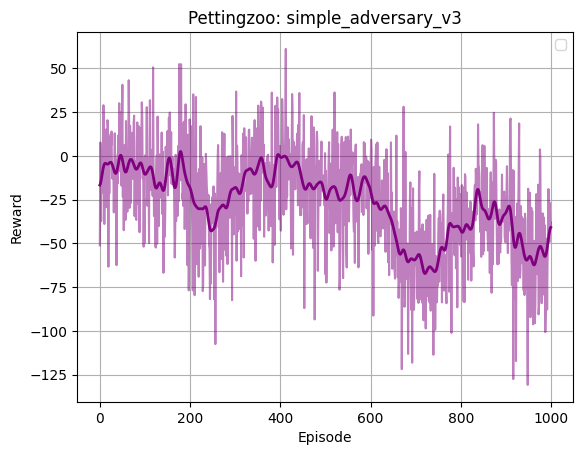

In [ ]:

# 4 Save the rewards
reward_path = os.path.join(current_path, "model/" + scenario + f'/reward_{timestamp}.csv')
np.savetxt(current_path + f'/epi_reward_{scenario}_{timestamp}.txt', EPISODE_REWARD_BUFFER)

# 5 Plot the rewards
plt.plot(EPISODE_REWARD_BUFFER, color='purple', alpha=0.5)
plt.plot(np.arange(0, NUM_EPISODE, 1), gaussian_filter1d(EPISODE_REWARD_BUFFER, sigma=5), color='purple', linewidth=2)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'{scenario}')
plt.legend()
plt.savefig(f"reward_{scenario}_{timestamp}.png", format='png')
plt.grid()
plt.show()
